In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Conv2D, BatchNormalization, Activation, Dropout
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from keras.optimizers import Adam, SGD, RMSprop
from keras.activations import relu, selu, elu
from keras.callbacks import ModelCheckpoint
plt.style.use('ggplot')
plt.rcParams['font.size'] = 12
plt.rcParams['lines.color'] ='#000000'
np.random.seed(1234567)

In [2]:
train_path = '../input/sign-language-mnist/sign_mnist_train/sign_mnist_train.csv'
test_path = '../input/sign-language-mnist/sign_mnist_test/sign_mnist_test.csv'

In [3]:
# read data from CSV file
train = pd.read_csv(train_path)
train.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,13,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179


In [4]:
# high level summary
train.describe()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
count,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,...,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000
mean,12.318813,145.419377,148.500273,151.247714,153.546531,156.210891,158.411255,160.472154,162.339683,163.954799,...,141.104863,147.495611,153.325806,159.125332,161.969259,162.736696,162.906137,161.966454,161.137898,159.824731
std,7.287552,41.358555,39.942152,39.056286,38.595247,37.111165,36.125579,35.016392,33.661998,32.651607,...,63.751194,65.512894,64.427412,63.708507,63.738316,63.444008,63.509210,63.298721,63.610415,64.396846
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,6.000000,121.000000,126.000000,130.000000,133.000000,137.000000,140.000000,142.000000,144.000000,146.000000,...,92.000000,96.000000,103.000000,112.000000,120.000000,125.000000,128.000000,128.000000,128.000000,125.500000
50%,13.000000,150.000000,153.000000,156.000000,158.000000,160.000000,162.000000,164.000000,165.000000,166.000000,...,144.000000,162.000000,172.000000,180.000000,183.000000,184.000000,184.000000,182.000000,182.000000,182.000000
75%,19.000000,174.000000,176.000000,178.000000,179.000000,181.000000,182.000000,183.000000,184.000000,185.000000,...,196.000000,202.000000,205.000000,207.000000,208.000000,207.000000,207.000000,206.000000,204.000000,204.000000
max,24.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,...,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000


In [5]:
# empty(null) value inspection
# inner sum, sums over rows. outer sum, sums over columns
print(f"total empty values: {train.isna().sum().sum()}")

total empty values: 0


In [6]:
X = train.drop('label', axis=1) # features
y = to_categorical(train['label']) # one-hot encoded target

In [7]:
# utility function to reshape square black and white image
# assumes that image has equal width and height in pixels and image is a black and white image
def reshape_bw(X):
    samples, width, channel = X.shape[0], int(X.shape[1] ** (1/2)) ,1
    return X.values.reshape(samples, width, width, channel)  

In [8]:
X = reshape_bw(X)
width, height, channel = X.shape[1], X.shape[2], X.shape[3]

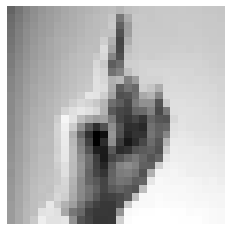

In [9]:
# helper function to help plotting image
def plot_image(X):
    _ = plt.imshow(X, cmap='gray')
    plt.axis('off')
    plt.show()
    
plot_image(X[0]) # plot sample image

In [10]:
# split data into train and validation set with same target distribution as before splitiing
X_train, X_val, y_train, y_val = train_test_split(X,y, stratify=y, test_size=0.15)

In [11]:
# create data preprocessor and fit on train set
generator = ImageDataGenerator(
    featurewise_center=True, 
    featurewise_std_normalization=True, 
)
generator.fit(X_train)

In [12]:
# initialize model
model = Sequential()
model.add(Conv2D(32, (5, 5), padding="same", input_shape=(width, height, channel)))
model.add(BatchNormalization())
model.add(Activation(relu))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (5, 5), padding="same"))
model.add(BatchNormalization())
model.add(Activation(relu))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (5, 5),padding="same"))
model.add(BatchNormalization())
model.add(Activation(relu))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dropout(0.4))
model.add(Dense(64))
model.add(BatchNormalization())
model.add(Activation(relu))
model.add(Dropout(0.25))
model.add(Dense(y.shape[1], activation='softmax'))

In [13]:
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

In [14]:
# initialize callback to save best model so far
cb = [ModelCheckpoint('model.h5', monitor='val_loss', mode='min',save_best_only=True)]

In [15]:
# train model
history = model.fit_generator(generator.flow(X_train, y_train, batch_size=32), \
                              epochs=25, \
                              validation_data=generator.flow(X_val,y_val,batch_size=32), \
                              callbacks=cb)

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/25
730/730 [==============================] - 9s 6ms/step - loss: 1.3734 - accuracy: 0.6523 - val_loss: 0.0193 - val_accuracy: 1.0000
Epoch 2/25
730/730 [==============================] - 4s 6ms/step - loss: 0.0374 - accuracy: 0.9981 - val_loss: 0.0029 - val_accuracy: 1.0000
Epoch 3/25
730/730 [==============================] - 4s 5ms/step - loss: 0.0265 - accuracy: 0.9975 - val_loss: 0.0014 - val_accuracy: 1.0000
Epoch 4/25
730/730 [==============================] - 4s 5ms/step - loss: 0.0243 - accuracy: 0.9955 - val_loss: 4.2431e-04 - val_accuracy: 1.0000
Epoch 5/25
730/730 [==============================] - 4s 6ms/step - loss: 0.0081 - accuracy: 0.9993 - val_loss: 0.0040 - val_accuracy: 0.9993
Epoch 6/25
730/730 [==============================] - 4s 6ms/step - loss: 0.0221 - accuracy: 0.9946 - val_loss: 1.1352e-04 - val_accuracy: 1.0000
Epoch 7/25
730/730 [==============================] - 4s 6ms/step - loss: 0.0082 - accuracy: 0.9977 - val_loss: 2.0957e-04 - val_accuracy: 1

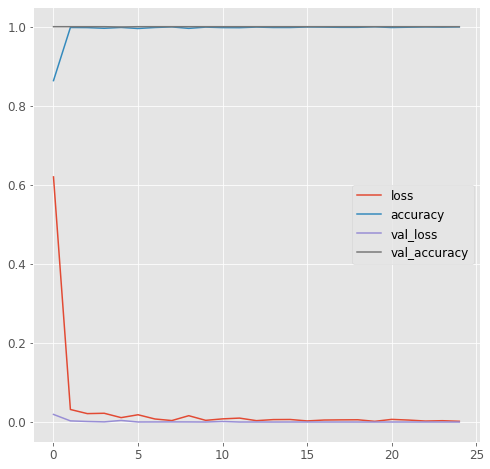

In [16]:
# observe model performance during training
_ = pd.DataFrame(history.history).plot(figsize=(8,8))

In [17]:
# evaluate model on unseen data
test = pd.read_csv(test_path)
test.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,6,149,149,150,150,150,151,151,150,151,...,138,148,127,89,82,96,106,112,120,107
1,5,126,128,131,132,133,134,135,135,136,...,47,104,194,183,186,184,184,184,182,180
2,10,85,88,92,96,105,123,135,143,147,...,68,166,242,227,230,227,226,225,224,222
3,0,203,205,207,206,207,209,210,209,210,...,154,248,247,248,253,236,230,240,253,255
4,3,188,191,193,195,199,201,202,203,203,...,26,40,64,48,29,46,49,46,46,53


In [18]:
X_test = test.drop('label', axis=1)
y_test = test['label']
X_test = reshape_bw(X_test)
y_test = to_categorical(y_test)
X_test.shape

(7172, 28, 28, 1)

label: 6


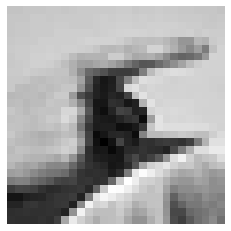

In [19]:
print(f"label: {np.argmax(model.predict(np.expand_dims([X_test[0]], axis=-1), verbose=0))}")
plot_image(X_test[0])

In [20]:
loss, acc = model.evaluate(generator.flow(X_test,y_test,batch_size=32))
print()
print(f"model loss: {loss}")
print(f"model accuracy:{round(acc*100,2)} %")

225/225 [==============================] - 1s 3ms/step - loss: 0.0215 - accuracy: 0.9930

model loss: 0.021509403362870216
model accuracy:99.3 %
